In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from muutils.dbg import dbg_auto, grep_repr

from spd.clustering.activations import component_activations, process_activations
from spd.clustering.merge import compute_merge_costs, merge_iteration
from spd.clustering.merge_matrix import GroupMerge
from spd.clustering.sweep import SweepConfig, run_hyperparameter_sweep
from spd.clustering.util import named_lambda
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidualMLPDataset
from spd.models.component_model import ComponentModel
from spd.registry import CANONICAL_RUNS
from spd.utils.data_utils import DatasetGeneratedDataLoader

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# magic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
component_model, cfg, path = ComponentModel.from_pretrained(CANONICAL_RUNS["resid_mlp1"])
component_model.to(DEVICE);

Downloaded checkpoint from /home/miv/projects/MATS/spd/wandb/5mk5h1lk/files/resid_mlp.pth


In [3]:
N_SAMPLES: int = 512

dataset = ResidualMLPDataset(
    n_features=component_model.patched_model.config.n_features,
    feature_probability=cfg.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,  # Our labels will be the output of the target model
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=cfg.task_config.data_generation_type,
    # synced_inputs=synced_inputs,
)

dbg_auto(
    dict(
        n_features=dataset.n_features,
        feature_probability=dataset.feature_probability,
        data_generation_type=dataset.data_generation_type,
    )
)

dataloader = DatasetGeneratedDataLoader(dataset, batch_size=N_SAMPLES, shuffle=False)

[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=3, key_types={str}, val_types={float, int, str}>
  n_features: 100
  feature_probability: 0.01
  data_generation_type: 'at_least_zero_active'


In [4]:
# dbg_auto(component_model.__dict__);
# dbg_auto(component_model.patched_model.__dict__);

# this doesnt find anything
grep_repr(str(component_model.patched_model.__dict__), "sigmoid", loose=True)
grep_repr(str(component_model.__dict__), "sigmoid", loose=True)

In [5]:
ci = component_activations(
    component_model,
    dataloader,
    device=DEVICE,
    # threshold=0.1,
    # TODO: where can we find this in the model itself???
    sigmoid_type="hard",
)

dbg_auto(ci);

[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=2, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.01 σ=0.09 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▂▂▂▃▄| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗
  layers.0.mlp_out: μ=0.05 σ=0.18 x̃=0.00 R=[0.00,0.97] ℙ˪=|█▅▅▅▅▅▅| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗


[ activations.py:295 ] total_c = 200
[ activations.py:315 ] (len(dead_components_lst), len(labels)) = (50, 150)
[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=7, key_types={str}, val_types={Tensor, int, list}>
  activations: μ=0.04 σ=0.17 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▄▅▅| shape=(512,150) dtype=torch.float32 device=cuda:0 ∇✗
  labels: <list of len()=150, types={str}>
  coactivations: μ=2.06 σ=4.68 x̃=0.10 R=[0.00,47.86] ℙ˪=|█▆▆▃▂▃▂| shape=(150,150) dtype=torch.float32 device=cuda:0 ∇✗
  dead_components_lst: <list of len()=50, types={str}>
  n_components_original: 200
  n_components_alive: 150
  n_components_dead: 50


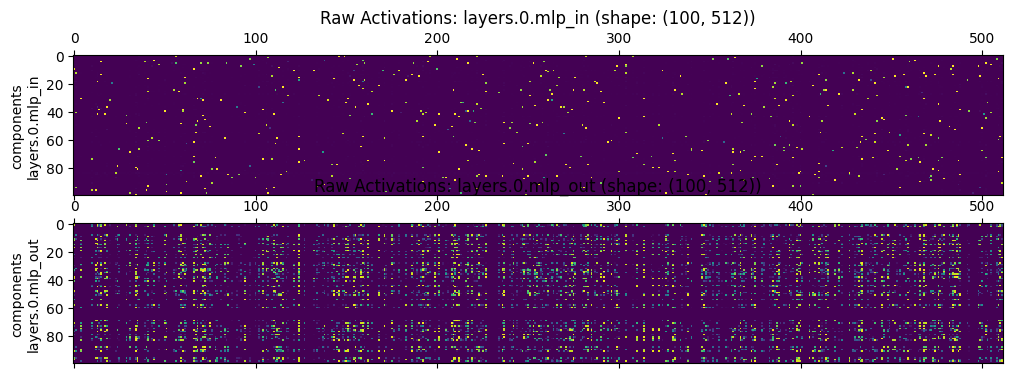

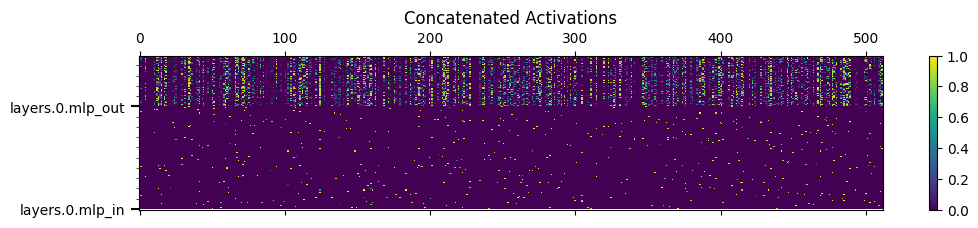

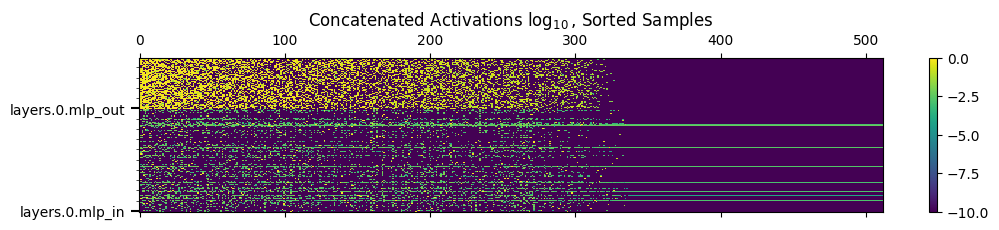

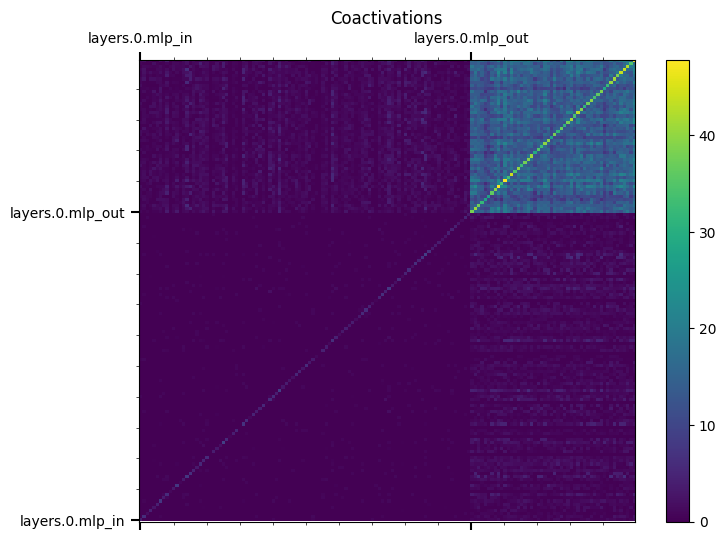

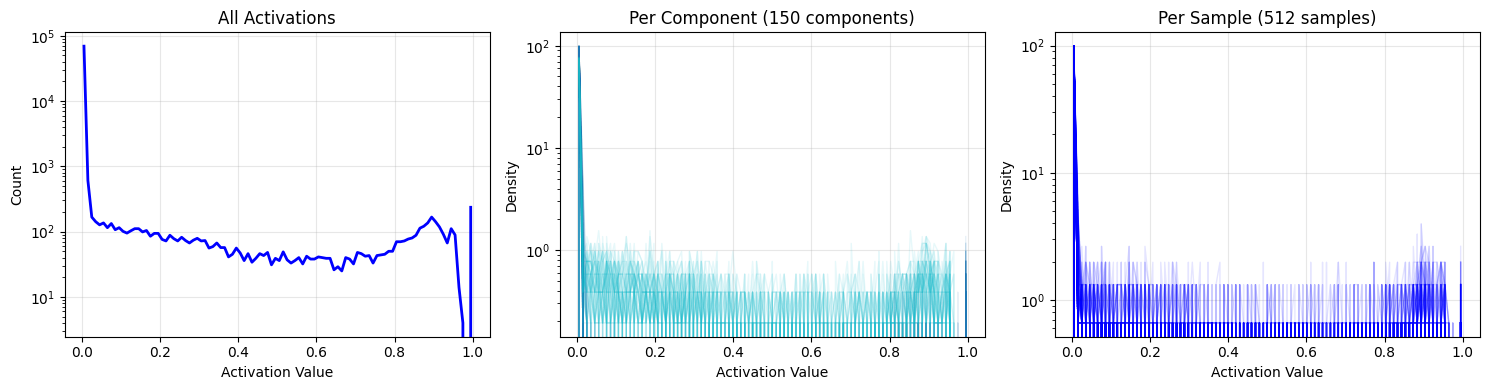

In [6]:
coa = process_activations(
    ci,
    filter_dead_threshold=0.001,
    plots=True,  # Plot the processed activations
    # plot_title="Processed Activations",
);

$$
	F_g := \frac{\alpha}{n}
	\Bigg[
		d(A(g)) \cdot Q^T 
		+ Q \cdot d(A(g))^T
		- \Big(
			R \mathbf{1}^T
			+ \mathbf{1} R^T + \alpha^{-1}
		\Big) 
		\odot A(g)
	\Bigg]
$$

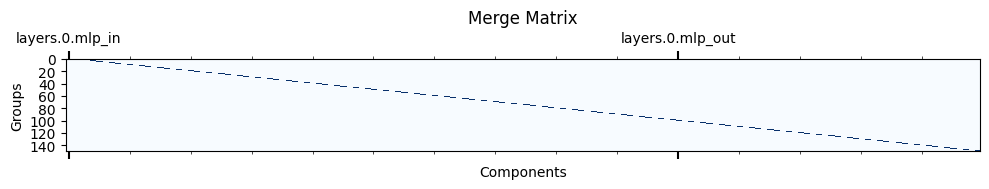

/home/miv/projects/MATS/spd/spd/clustering/merge.py:37: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  diag @ ranks.T


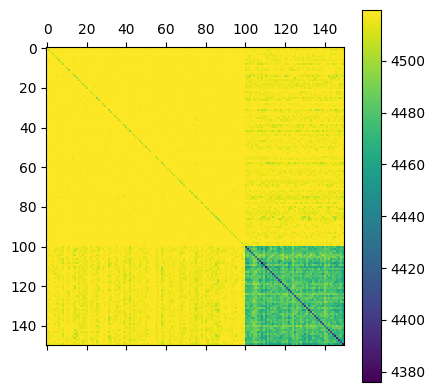

In [7]:
gm_ident = GroupMerge.identity(n_components=coa["n_components_alive"])
gm_ident.plot(figsize=(10, 2), component_labels=coa["labels"])
costs = compute_merge_costs(
    coact=coa["coactivations"],
    merges=gm_ident,
)
plt.matshow(costs.cpu(), cmap="viridis")
plt.colorbar();

/home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/tensor_info.py:264: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bins = np.histogram(A_hist, bins=hist_bins)
[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: μ=0.04 σ=0.19 x̃=0.00 R=[0,1] ℙ˪=|█     ▆| shape=(512,150) dtype=torch.bool device=cuda:0 ∇✗


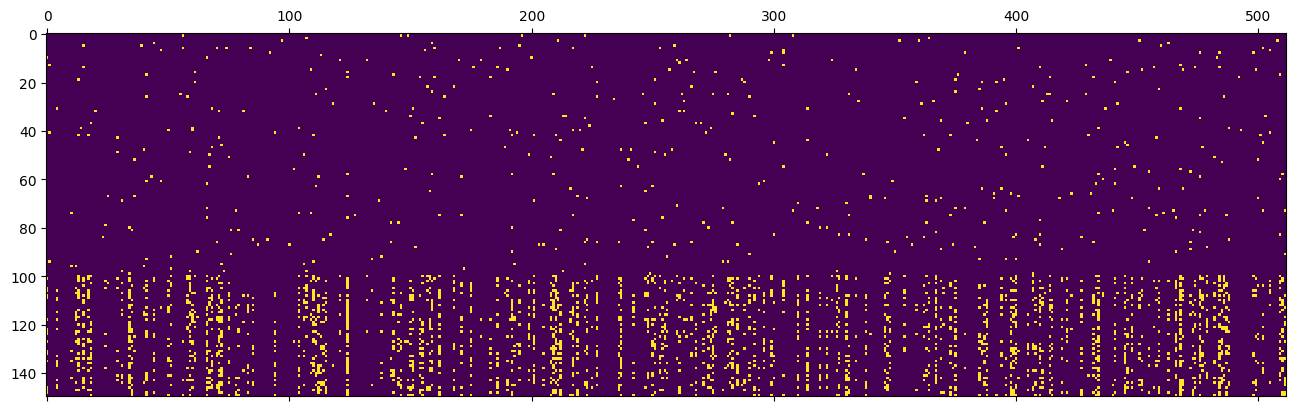

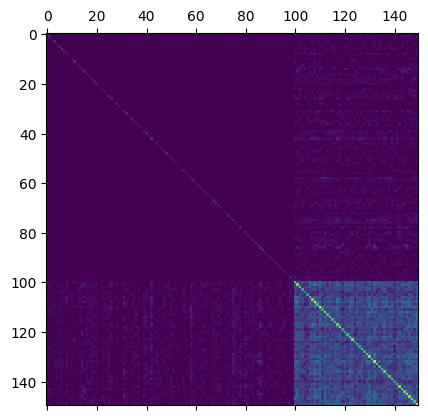

In [8]:
act_bool = coa["activations"] > 0.5
plt.matshow(act_bool.cpu().T, cmap="viridis")
dbg_auto(act_bool)
plt.matshow((act_bool.float().T @ act_bool.float()).cpu(), cmap="viridis")

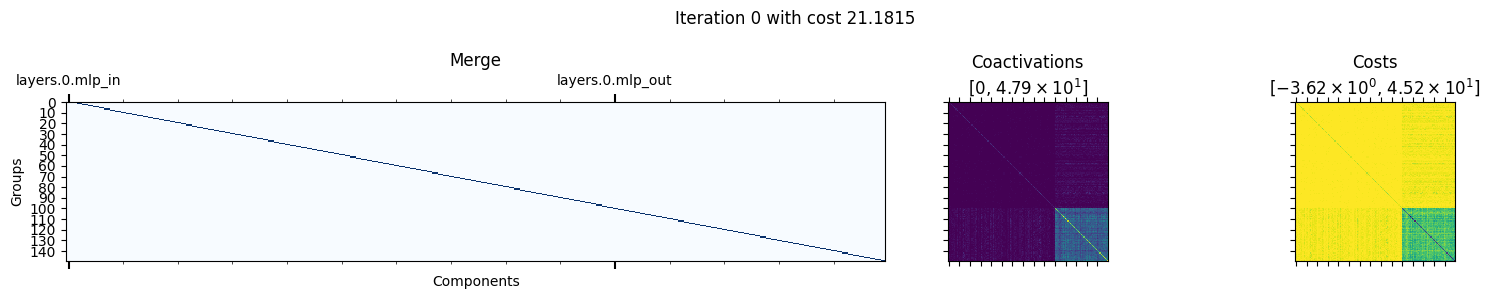

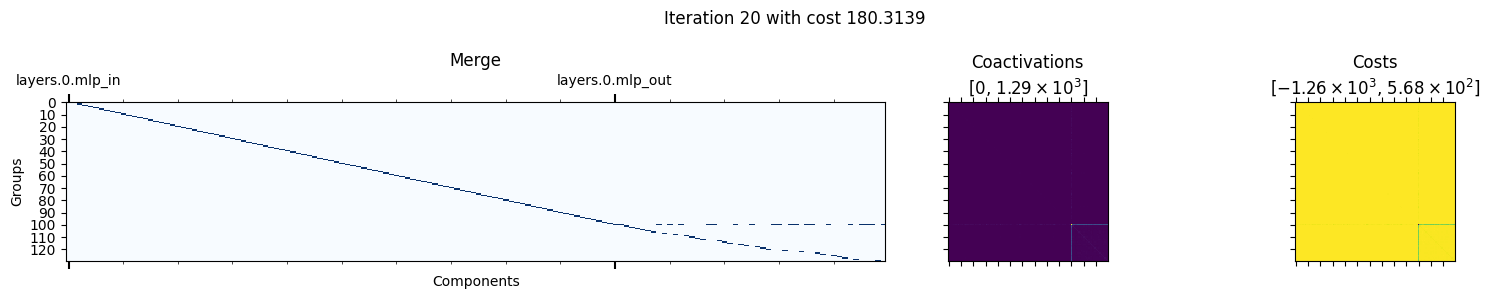

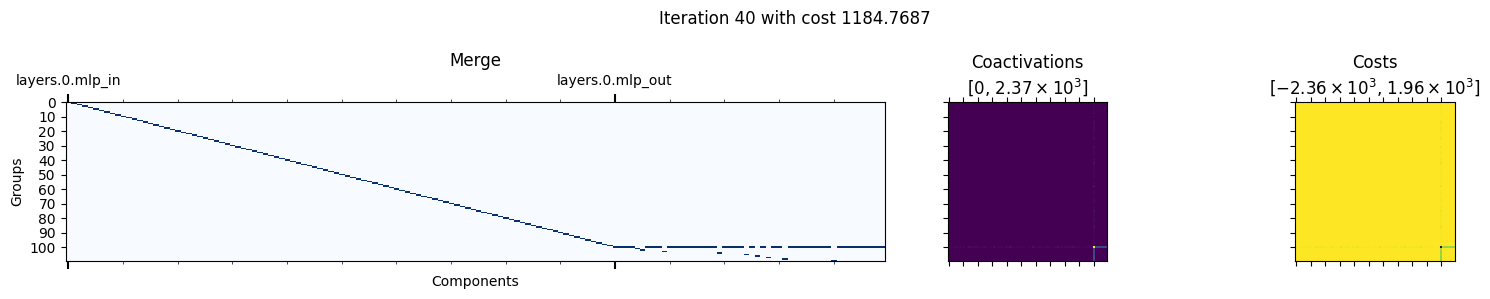

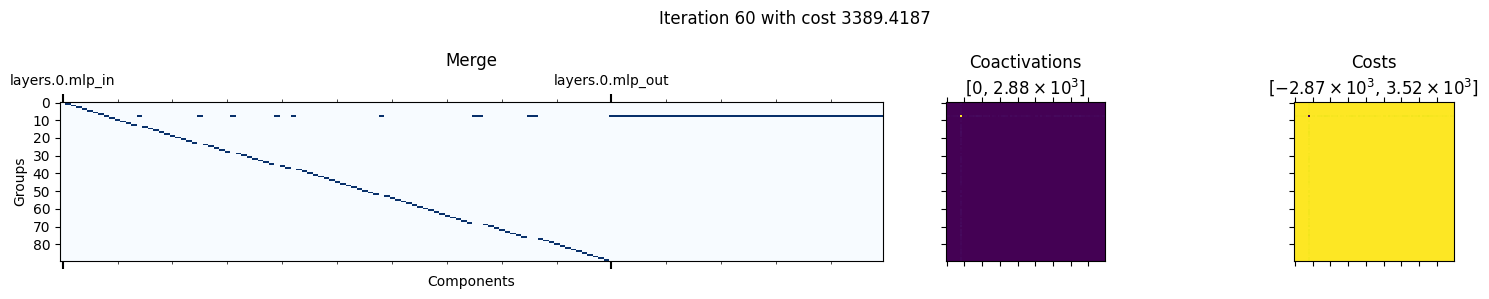

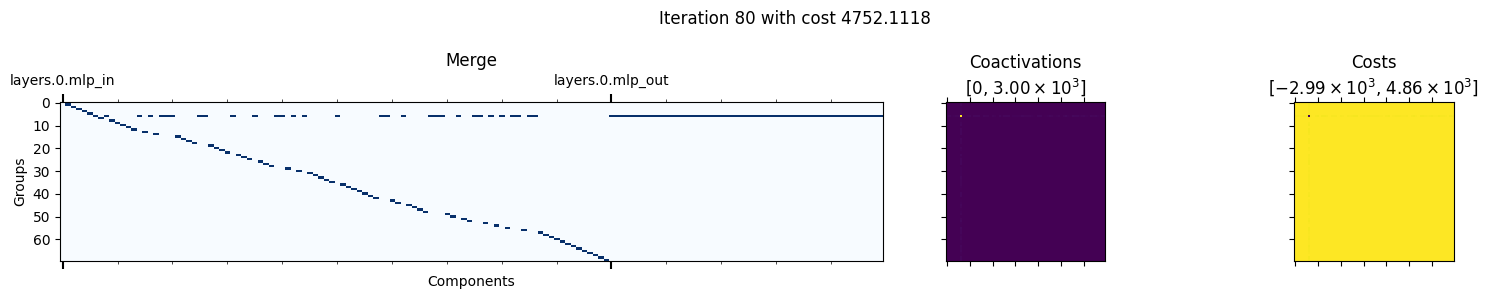

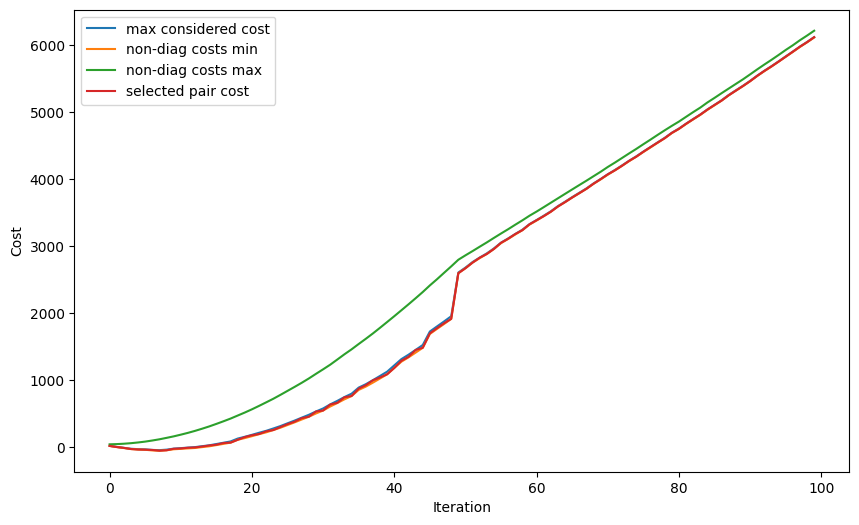

In [9]:
from spd.clustering.merge import MergeConfig, MergePlotConfig

merge_iteration(
    activations=coa["activations"],
    component_labels=coa["labels"],
    merge_config=MergeConfig(
        activation_threshold=None,
        alpha=0.01,
        iters=100,
        check_threshold=0.05,
        pop_component_prob=0.0,
        rank_cost_fn=lambda x: 1.0,
        stopping_condition=None,
    ),
    plot_config=MergePlotConfig(
        plot_every=20,
        plot_every_min=0,
        save_pdf=False,
        # pdf_prefix="merge_iteration",
        figsize=(16, 3),
        figsize_final=(10, 6),
        tick_spacing=10,
        plot_final=True,
    ),
);

/tmp/ipykernel_772152/1342956652.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


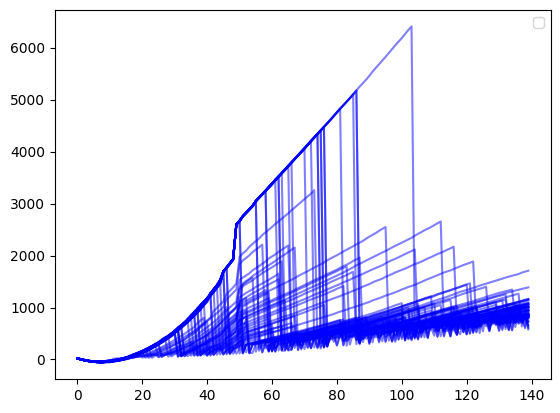

In [63]:
from spd.clustering.merge import MergeHistory, merge_iteration_ensemble

ENSEMBLE: list[MergeHistory] = merge_iteration_ensemble(
    activations=coa["activations"],
    component_labels=coa["labels"],
    merge_config=MergeConfig(
        activation_threshold=None,
        alpha=0.01,
        iters=140,
        check_threshold=0.1,
        pop_component_prob=0.1,
        rank_cost_fn=lambda x: 1.0,
        stopping_condition=None,
    ),
    plot_config=MergePlotConfig(
        plot_every=999,
        plot_every_min=999,
		# plot_every=5,
        save_pdf=False,
        # pdf_prefix="merge_iteration",
        figsize=(16, 3),
        figsize_final=(10, 6),
        tick_spacing=10,
        plot_final=False,
    ),
	ensemble_size=64,
)


for x in ENSEMBLE:
    plt.plot(x.non_diag_costs_min, "b-", alpha=0.5)
plt.legend()

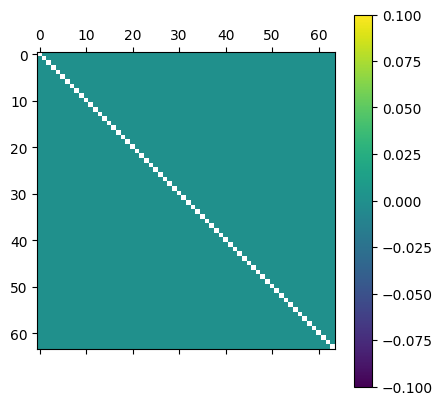

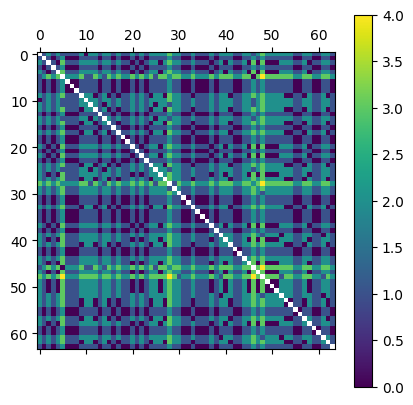

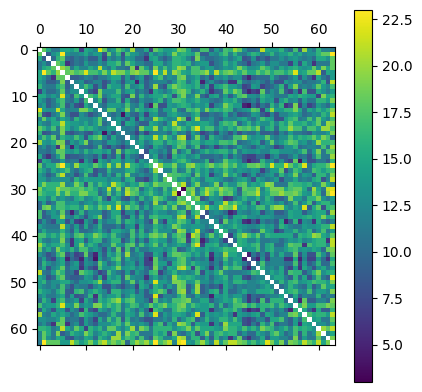

In [64]:
# compute the matrix of pairwise distances between each group merge at every single iteration

n_iterations: int = len(ENSEMBLE[0].k_groups)

# for x in ENSEMBLE:
# 	plt.plot(x.k_groups)

# plt.show()

from jaxtyping import Float

DISTANCES: Float[np.ndarray, "n_iters n_ens n_ens"] = np.full(
	(n_iterations, len(ENSEMBLE), len(ENSEMBLE)),
	float("nan"),
)

for i in range(n_iterations):
	for j in range(len(ENSEMBLE)):
		for k in range(len(ENSEMBLE)):
			if j == k:
				continue
			d = ENSEMBLE[j].merges[i].dist(ENSEMBLE[k].merges[i])
			DISTANCES[i, j, k] = d
			DISTANCES[i, k, j] = DISTANCES[i, j, k]  # make it symmetric


for i in range(n_iterations):
	if i % 50 == 0:
		plt.matshow(DISTANCES[i], cmap="viridis")
		plt.colorbar()



In [65]:
dbg_auto(DISTANCES)
dists_flatten = DISTANCES.reshape(DISTANCES.shape[0], -1)
dbg_auto(dists_flatten)

[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: 🚨 NANvals=8960 (1.6%) μ=8.69 σ=4.62 x̃=8.00 R=[0.00,31.00] ℙ=|▅▇█▃▁  | shape=(140,64,64) dtype=float64
[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: 🚨 NANvals=8960 (1.6%) μ=8.69 σ=4.62 x̃=8.00 R=[0.00,31.00] ℙ=|▅▇█▃▁  | shape=(140,4096) dtype=float64


array([[nan,  0.,  0., ...,  0.,  0., nan],
       [nan,  2.,  0., ...,  1.,  2., nan],
       [nan,  4.,  0., ...,  3.,  4., nan],
       ...,
       [nan,  5.,  3., ...,  4.,  5., nan],
       [nan,  5.,  5., ...,  4.,  5., nan],
       [nan,  3.,  3., ...,  4.,  5., nan]], shape=(140, 4096))

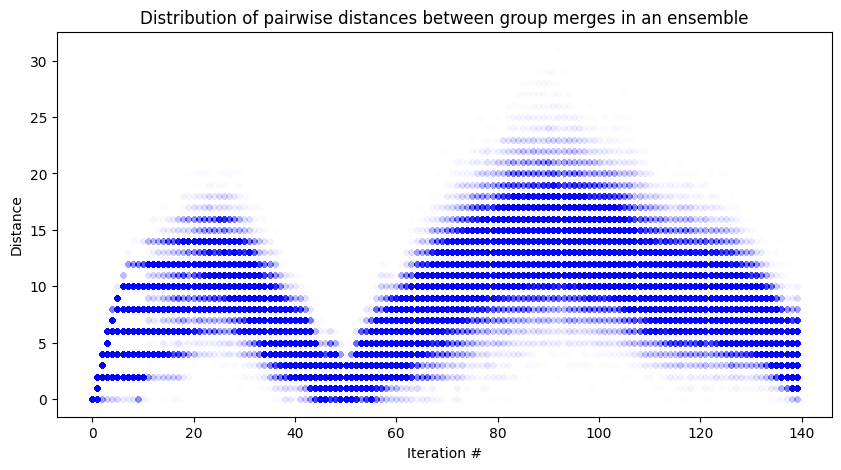

In [72]:
# plot the distribution of distances at each iteration
n_samples: int = dists_flatten.shape[1]
plt.figure(figsize=(10, 5))
for i in range(n_iterations):
	plt.plot(
		np.full((n_samples), i),
		dists_flatten[i],
		"bo",
		alpha=0.005,
		markersize=5,
		markeredgewidth=0,
	)
plt.xlabel("Iteration #")
plt.ylabel("Distance")
plt.title("Distribution of pairwise distances between group merges in an ensemble")
plt.show()

In [ ]:
# Create sweep configuration



sweep_config = SweepConfig(
    # activation_thresholds=[0.001, 0.002, 0.005],
    activation_thresholds=np.logspace(-4, -1, 4).tolist(),
    # check_thresholds=[0.05, 0.1, 0.2],
    check_thresholds=np.logspace(-2, 0, 3).tolist(),
    # alphas=[0.1, 1.0, 10.0],
    alphas=np.logspace(-3, 0, 4).tolist(),
    rank_cost_funcs=[
        named_lambda("constant_1", lambda _: 1.0),
        # named_lambda("constant_10", lambda _: 10.0),
        # named_lambda("constant_100", lambda _: 100.0),
        named_lambda("linear", lambda c: c),
        named_lambda("log", lambda c: np.log(c + 1)),
    ],
    iters=50,
)

# Run sweep
sweep_results: list[MergeHistory] = run_hyperparameter_sweep(coa["activations"], sweep_config)

print(f"\\n{len(sweep_results) = }")
for i, result in enumerate(sweep_results[:3]):
    print(
        f"{i + 1}: thresh={result.config.activation_threshold}, check={result.config.check_threshold}, α={result.config.alpha}, rank={result.config.rank_cost_name}"
    )
    print(f"   iters={result.total_iterations}, groups={result.final_k_groups}")

len(configs) = 72


100%|██████████| 72/72 [00:05<00:00, 12.72it/s]

len(results) = 72
\nlen(sweep_results) = 72
1: thresh=0.0001, check=0.01, α=0.001, rank=constant_1
   iters=50, groups=101
2: thresh=0.0001, check=0.01, α=0.001, rank=linear
   iters=50, groups=101
3: thresh=0.0001, check=0.01, α=0.001, rank=log
   iters=50, groups=101


/home/miv/projects/MATS/spd/spd/clustering/sweep.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


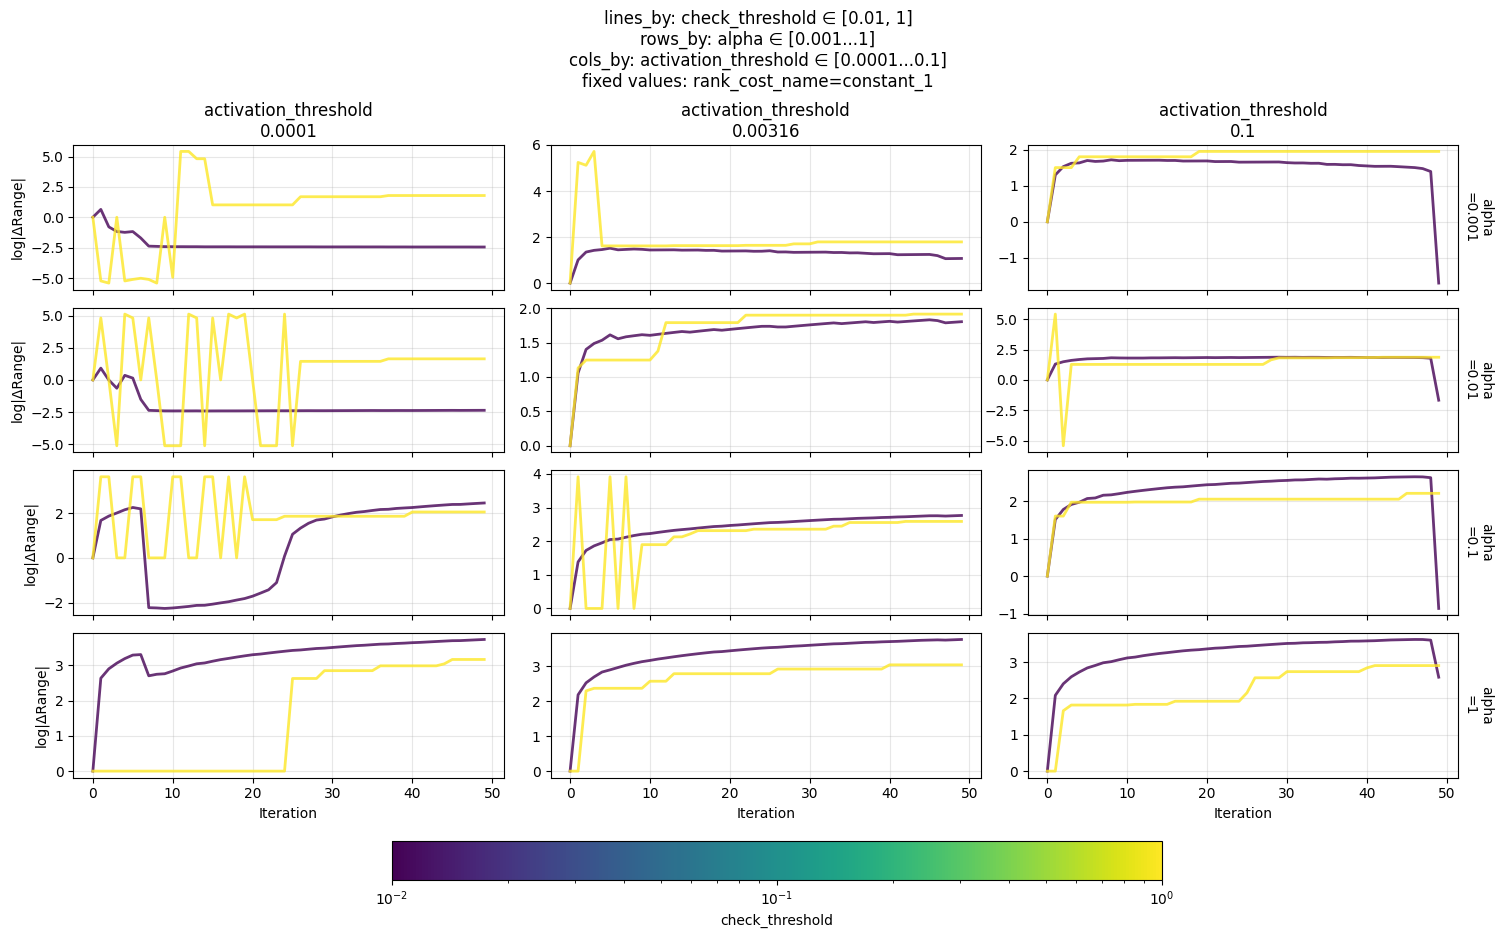

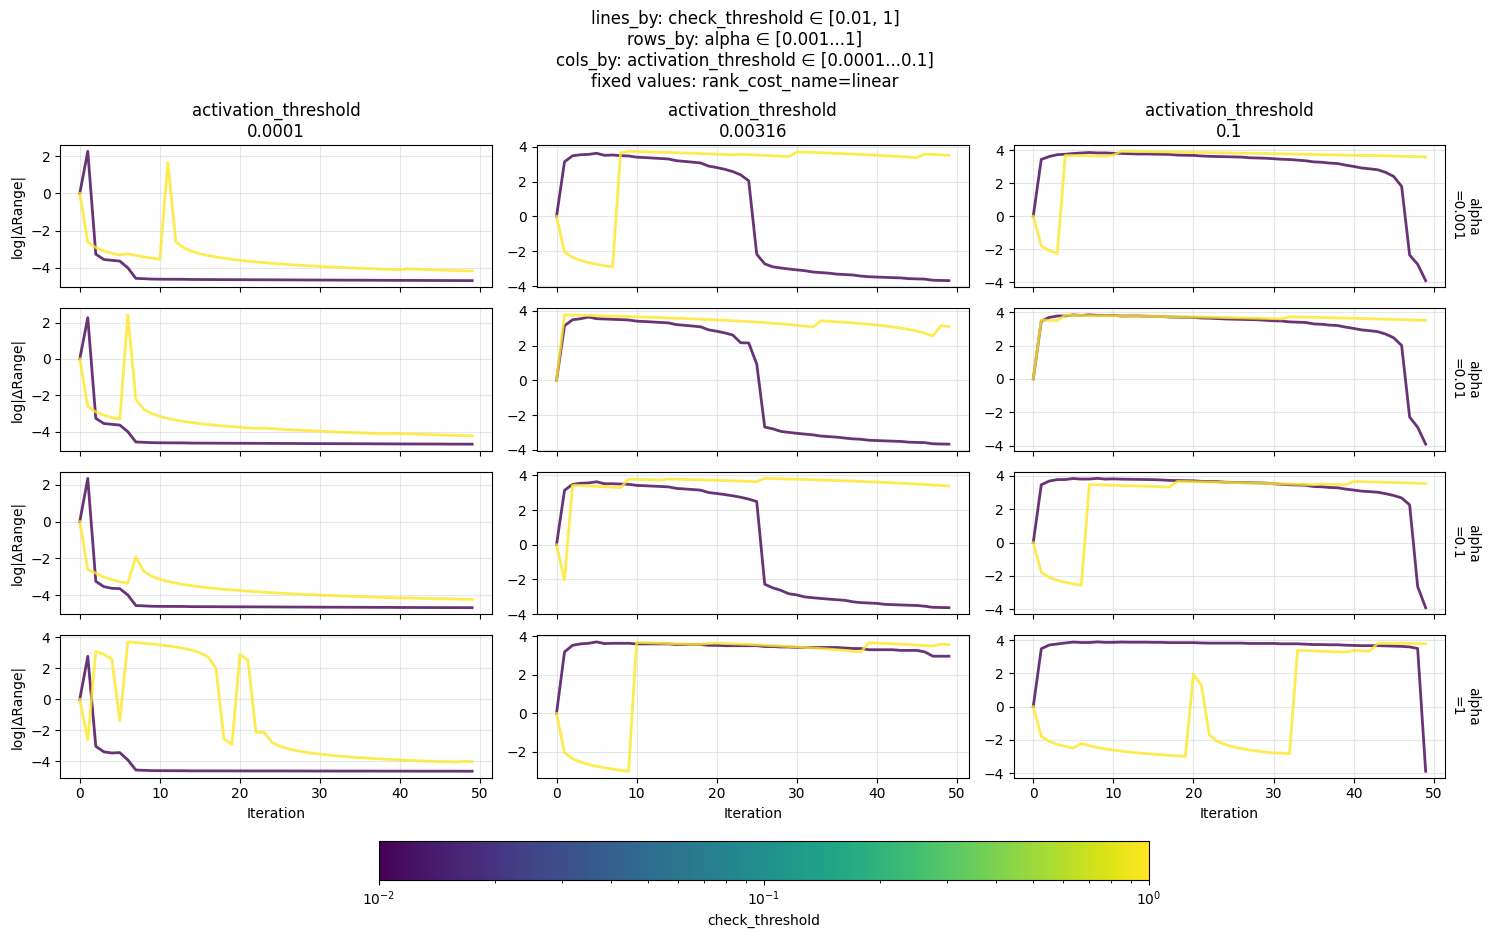

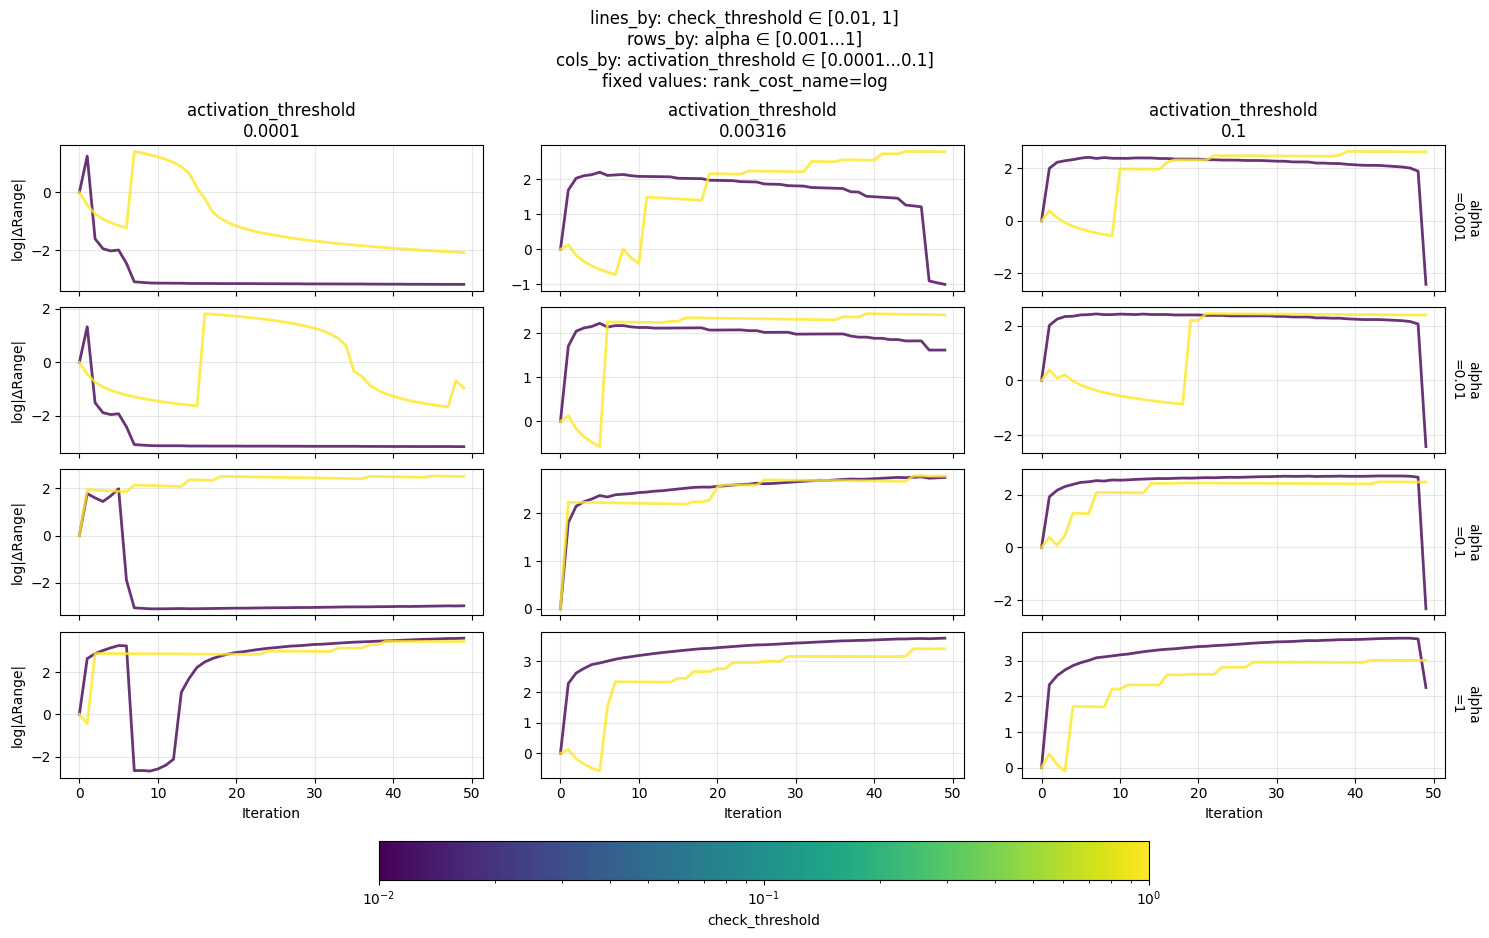

In [13]:
# Evolution histories
from spd.clustering.sweep import plot_evolution_histories

# plot_evolution_histories(
#     sweep_results,
#     metric='non_diag_costs_min',
#     lines_by='alpha',
#     cols_by='activation_threshold',
#     rows_by='check_threshold',
# 	fixed_params={'rank_cost_name': 'constant_0.1'},  # Example fixed parameter
# )

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
    metric="costs_range",
    cols_by="activation_threshold",
    rows_by="alpha",
    lines_by="check_threshold",
    fixed_params={"rank_cost_name": "constant_1"},
)

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
    metric="costs_range",
    cols_by="activation_threshold",
    rows_by="alpha",
    lines_by="check_threshold",
    fixed_params={"rank_cost_name": "linear"},
)

plot_evolution_histories(
    sweep_results,
    # metric='non_diag_costs_min',
    metric="costs_range",
    cols_by="activation_threshold",
    rows_by="alpha",
    lines_by="check_threshold",
    fixed_params={"rank_cost_name": "log"},
)

# plot_evolution_histories(
#     sweep_results,
#     metric='non_diag_costs_min',
#     lines_by='activation_threshold',
#     cols_by='rank_cost_name',
#     rows_by='check_threshold',
# 	fixed_params={'alpha': 0.001},  # Example fixed parameter
# )

In [ ]:
# %% Stopping Condition Examples

# Example: Stop when cost reaches 2x original
from spd.clustering.sweep import cost_ratio_stopping_condition

stop_at_2x = cost_ratio_stopping_condition(2.0)

# Run with stopping condition
result_with_stop = merge_iteration(
    coact=(coa["coactivations"] > 0.002).float().T @ (coa["coactivations"] > 0.002).float(),
    activation_mask=coa["coactivations"] > 0.002,
    alpha=1.0,
    check_threshold=0.1,
    stopping_condition=stop_at_2x,
    plot_every=None,
    plot_final=False,
)

print(f"{result_with_stop['total_iterations'] = }")
print(f"{result_with_stop['final_k_groups'] = }")

# You can also use the stopping condition in sweeps by modifying sweep_config.iters
# or adding the stopping condition to merge_iteration calls in the sweep